In [1]:
#import package
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils import data as ds
from model import RNN,LSTM,GRU
import torch.nn.functional as F
import ast

from scipy.stats import pearsonr, spearmanr
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# data = [
#     [[0.1, 0.2, 0.3, 0.5], [0.1, 0.2, 0.3, 0.2], [0.1, 0.2, 0.3, 0.3], [0.1, 0.2, 0.3, 0.4], [0.1, 0.2, 0.3, 0.1]],   # report1 representation
#     [[0.1, 0.2, 0.3, 0.5], [0.1, 0.2, 0.3, 0.3]],
#     [[0.1, 0.2, 0.3, 0.5], [0.1, 0.2, 0.3, 0.3], [0.1, 0.2, 0.3, 0.4], [0.1, 0.2, 0.3, 0.2], [0.1, 0.2, 0.3, 0.5]],   # report2 representation
#     [[0.1, 0.2, 0.3, 0.5], [0.1, 0.2, 0.3, 0.4], [0.1, 0.2, 0.3, 0.3], [0.1, 0.2, 0.3, 0.2], [0.1, 0.2, 0.3, 0.5]]    # report2 representation
# ]

# def trim_data(data, max_length=3):
#     trimmed_data = []
#     for sample in data:
#         if len(sample) > max_length:
#             # 找出最里面第四个维度的值
#             fourth_values = [item[3] for item in sample]
#             # 找出要保留的前max_length个最大值的索引
#             indices_to_keep = sorted(range(len(fourth_values)), key=lambda i: fourth_values[i], reverse=False)[:max_length]
#             # 按原顺序保留这些索引对应的元素
#             trimmed_report = [sample[i] for i in sorted(indices_to_keep)]
#             trimmed_data.append(trimmed_report)
#         else:
#             trimmed_data.append(sample)
#     return trimmed_data

# trimmed_data = trim_data(data)
# print(trimmed_data)


In [3]:
class MyDataset1(ds.Dataset):
    def __init__(self, X, Y):
        self.samples = X
        self.labels = Y

    def __getitem__(self, index):
        sample = self.samples[index]
        label = [self.labels[index]]
        sample = torch.Tensor(sample).float()
        label = torch.Tensor(label).float()
        return sample, label

    def __len__(self):
        return len(self.samples)


In [4]:
def collate_fn(batch):
    samples, labels = zip(*batch)
    # Pad the samples
    samples_padded = torch.nn.utils.rnn.pad_sequence(samples, batch_first=True, padding_value=0.0)
    labels = torch.stack(labels)
    return samples_padded, labels


In [5]:
'''#regression dataset
class MyDataset1(ds.Dataset):
    def __init__(self, X, Y):
        self.samples = X
        self.labels = Y

    def __getitem__(self, index):
        sample = self.samples[index]
        label = [self.labels[index]]
        #print(label)
        sample=torch.Tensor(sample).float()
        label= torch.Tensor(label).float()

        return sample, label

    def __len__(self):
        return len(self.samples)'''

'#regression dataset\nclass MyDataset1(ds.Dataset):\n    def __init__(self, X, Y):\n        self.samples = X\n        self.labels = Y\n\n    def __getitem__(self, index):\n        sample = self.samples[index]\n        label = [self.labels[index]]\n        #print(label)\n        sample=torch.Tensor(sample).float()\n        label= torch.Tensor(label).float()\n\n        return sample, label\n\n    def __len__(self):\n        return len(self.samples)'

In [6]:
report_repre=pd.read_csv('C:/Users/lenovo/Desktop/UCL/Final dissertation/code/Midway Results/ESGOverallData.csv')
report_repre.dropna(inplace=True)

In [7]:
def generate_data(df):
    x_train=[]
    y_train=[]
    for index,row in df.iterrows():
        x_train.append(ast.literal_eval(row["ESGData"]))
        y_train.append(float(row["BloombergOverall"]))
    return x_train,y_train


In [8]:
x,y=generate_data(report_repre)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

In [10]:
# x=x[0:5]

In [11]:
len(x_train)

387

In [12]:
'''def pad_time_series(data, padding_value=0.0):
    final_result = []
    processed_data = []

    # Step 1: Preprocess - Remove timesteps where the fourth value is greater than 0.5
    for sample in data:
        processed_sample = [timestep for timestep in sample if timestep[3] <= 0.5]
        processed_data.append(processed_sample)

    # Step 2: Calculate the average target length
    target_length = int(np.mean([len(sample) for sample in processed_data]))

    # Step 3: Pad or Trim the sequences
    for sample in processed_data:
        if len(sample) < target_length:
            # Pad the sample
            for _ in range(target_length - len(sample)):
                sample.append([padding_value for _ in range(4)])
            final_result.append(sample)
        
        elif len(sample) > target_length:
            # Trim the sample by removing highest fourth values
            fourth_values = [item[3] for item in sample]
            indices_to_keep = sorted(range(len(fourth_values)), key=lambda i: fourth_values[i], reverse=False)[:target_length]
            trimmed_sample = [sample[i] for i in sorted(indices_to_keep)]
            final_result.append(trimmed_sample)
        
        else:
            # If already the correct length
            final_result.append(sample)

    return final_result

x = pad_time_series(x, padding_value=0.25)
len(x[0])'''

'def pad_time_series(data, padding_value=0.0):\n    final_result = []\n    processed_data = []\n\n    # Step 1: Preprocess - Remove timesteps where the fourth value is greater than 0.5\n    for sample in data:\n        processed_sample = [timestep for timestep in sample if timestep[3] <= 0.5]\n        processed_data.append(processed_sample)\n\n    # Step 2: Calculate the average target length\n    target_length = int(np.mean([len(sample) for sample in processed_data]))\n\n    # Step 3: Pad or Trim the sequences\n    for sample in processed_data:\n        if len(sample) < target_length:\n            # Pad the sample\n            for _ in range(target_length - len(sample)):\n                sample.append([padding_value for _ in range(4)])\n            final_result.append(sample)\n        \n        elif len(sample) > target_length:\n            # Trim the sample by removing highest fourth values\n            fourth_values = [item[3] for item in sample]\n            indices_to_keep = sorte

In [13]:
def pad_time_series(data, target_length=None, padding_value=0.0):
    # Determine the target length if not provided
    final_result=[]
    if target_length is None:
        target_length = max(len(sample) for sample in data)

    for sample in data:
        if len(sample) < target_length:
            for _ in range(target_length - len(sample)):
                sample.append([padding_value for _ in range(4)])
            final_result.append(sample)
        
        elif len(sample) > target_length:
            fourth_values = [item[3] for item in sample]
            indices_to_keep = sorted(range(len(fourth_values)), key=lambda i: fourth_values[i], reverse=False)[:target_length]
            trimmed_report = [sample[i] for i in sorted(indices_to_keep)]
            final_result.append(trimmed_report)
        
        else:
            final_result.append(sample)

    return final_result
            

    return data


x = pad_time_series(x, 200, padding_value=0.25)
len(x[0])

200

In [14]:
'''
def mean_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))
def r_squared(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    print(y_true)
    if ss_tot == 0:
        return torch.tensor(0.0)  # or another appropriate value
    
    return 1 - (ss_res / ss_tot)

def mean_absolute_percentage_error(y_true, y_pred):
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100
def mean_squared_error(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)
'''

'\ndef mean_absolute_error(y_true, y_pred):\n    return torch.mean(torch.abs(y_true - y_pred))\ndef r_squared(y_true, y_pred):\n    ss_res = torch.sum((y_true - y_pred) ** 2)\n    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)\n    print(y_true)\n    if ss_tot == 0:\n        return torch.tensor(0.0)  # or another appropriate value\n    \n    return 1 - (ss_res / ss_tot)\n\ndef mean_absolute_percentage_error(y_true, y_pred):\n    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100\ndef mean_squared_error(y_true, y_pred):\n    return torch.mean((y_true - y_pred) ** 2)\n'

In [15]:
# def mean_absolute_error(y_true, y_pred):
#     return torch.mean(torch.abs(y_true - y_pred))

# def r_squared(y_true, y_pred, y_mean):
#     ss_res = torch.sum((y_true - y_pred) ** 2)
#     ss_tot = torch.sum((y_true - y_mean) ** 2)
#     print(y_mean)
#     if ss_tot == 0:
#         return torch.tensor(0.0)  # or another appropriate value
    
#     return 1 - (ss_res / ss_tot)

# def mean_absolute_percentage_error(y_true, y_pred):
#     return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

# def mean_squared_error(y_true, y_pred):
#     return torch.mean((y_true - y_pred) ** 2)

In [16]:
'''#training loop
def loop(model,train_loader,test_loader,optimizer,criterion,device,E=20):
    loss_all=[]
    for epoch in range(E): 
        loss_epoch=[]
        print(epoch)
        for samples, labels in train_loader:
            samples=samples.to(device)
            labels=labels.to(device)
            #print(samples.shape)
            #print(labels.shape)
        # Set the flag to training mode
            model.train()
            
            optimizer.zero_grad()
            outputs = model(samples)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            loss_epoch.append(float(loss.cpu()))
            #print(outputs)
        print(sum(loss_epoch)/len(loss_epoch))#训练集的平均loss
        loss_all.append(sum(loss_epoch)/len(loss_epoch))

    model.eval()
    result=[]
    for samples, true in test_loader:
        samples=samples.to(device)
        outputs = model(samples)
        result.append(float(outputs.cpu()))
        
    return result,loss_epoch,model'''

'#training loop\ndef loop(model,train_loader,test_loader,optimizer,criterion,device,E=20):\n    loss_all=[]\n    for epoch in range(E): \n        loss_epoch=[]\n        print(epoch)\n        for samples, labels in train_loader:\n            samples=samples.to(device)\n            labels=labels.to(device)\n            #print(samples.shape)\n            #print(labels.shape)\n        # Set the flag to training mode\n            model.train()\n            \n            optimizer.zero_grad()\n            outputs = model(samples)\n            loss = criterion(outputs.squeeze(), labels)\n            loss.backward()\n            optimizer.step()\n            loss_epoch.append(float(loss.cpu()))\n            #print(outputs)\n        print(sum(loss_epoch)/len(loss_epoch))#训练集的平均loss\n        loss_all.append(sum(loss_epoch)/len(loss_epoch))\n\n    model.eval()\n    result=[]\n    for samples, true in test_loader:\n        samples=samples.to(device)\n        outputs = model(samples)\n        resul

In [17]:
def information_coefficient(y_true, y_pred):
    # Convert tensors to numpy arrays for scipy functions
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    # Calculate Pearson correlation coefficient
    ic, _ = pearsonr(y_true_np, y_pred_np)
    return ic

def rank_information_coefficient(y_true, y_pred):
    # Convert tensors to numpy arrays for scipy functions
    y_true_np = y_true.cpu().numpy()
    y_pred_np = y_pred.cpu().numpy()
    # Calculate Spearman rank correlation coefficient
    rank_ic, _ = spearmanr(y_true_np, y_pred_np)
    return rank_ic

def mean_absolute_error(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

def r_squared(y_true, y_pred, y_mean):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - y_mean) ** 2)
    if ss_tot == 0:
        return torch.tensor(0.0)
    
    return 1 - (ss_res / ss_tot)

def mean_absolute_percentage_error(y_true, y_pred):
    return torch.mean(torch.abs((y_true - y_pred) / y_true)) * 100

def mean_squared_error(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)



In [18]:
def loop(model, train_loader, val_loader, optimizer, criterion, device, E=20):
    loss_all = []
    val_metrics = []

    for epoch in range(E): 
        loss_epoch = []
        model.train()
        
        for samples, labels in train_loader:
            samples = samples.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(samples)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            loss_epoch.append(float(loss.cpu()))

        avg_train_loss = sum(loss_epoch) / len(loss_epoch)
        print(f"Epoch {epoch + 1}/{E}, Training Loss: {avg_train_loss}")
        loss_all.append(avg_train_loss)

        # Validation
        model.eval()
        val_losses, mae, mape, r2_scores, ic_values, rank_ic_values = [], [], [], [], [], []
        total_labels = torch.tensor([]).to(device)
        total_outputs = torch.tensor([]).to(device)

        with torch.no_grad():
            for samples, labels in val_loader:
                samples = samples.to(device)
                labels = labels.to(device)
                outputs = model(samples)

                # Convert to 1D tensor before concatenation
                total_labels = torch.cat((total_labels, labels.view(-1)))
                total_outputs = torch.cat((total_outputs, outputs.squeeze().view(-1)))

                # Calculate the current y_mean
                y_mean = torch.mean(total_labels)

                val_loss = criterion(outputs.squeeze(), labels)
                val_losses.append(float(val_loss.cpu()))
                
                mae.append(mean_absolute_error(labels, outputs).cpu())
                mape.append(mean_absolute_percentage_error(labels, outputs).cpu())
                r2_scores.append(r_squared(labels, outputs, y_mean).cpu())

            # Calculate IC and Rank IC using the full set of labels and predictions for the epoch
            ic = information_coefficient(total_labels, total_outputs)
            rank_ic = rank_information_coefficient(total_labels, total_outputs)
            ic_values.append(ic)
            rank_ic_values.append(rank_ic)

        avg_val_loss = sum(val_losses) / len(val_losses)
        avg_mae = sum(mae) / len(mae)
        avg_mape = sum(mape) / len(mape)
        avg_r2 = sum(r2_scores) / len(r2_scores)
        avg_ic = sum(ic_values) / len(ic_values)
        avg_rank_ic = sum(rank_ic_values) / len(rank_ic_values)
        
        val_metrics.append((avg_val_loss, avg_mae, avg_mape, avg_r2, avg_ic, avg_rank_ic))
        # print(f"Validation - Loss: {avg_val_loss}, MAE: {avg_mae}, MAPE: {avg_mape}, R^2: {avg_r2}, IC: {avg_ic}, Rank IC: {avg_rank_ic}")

    return loss_all, val_metrics, model


In [19]:
'''def loop(model, train_loader, val_loader, optimizer, criterion, device, E=20):
    loss_all = []
    val_metrics = []

    for epoch in range(E): 
        loss_epoch = []
        model.train()
        
        for samples, labels in train_loader:
            samples = samples.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(samples)
            loss = criterion(outputs.squeeze(), labels)
            loss.backward()
            optimizer.step()
            loss_epoch.append(float(loss.cpu()))

        avg_train_loss = sum(loss_epoch) / len(loss_epoch)
        print(f"Epoch {epoch + 1}/{E}, Training Loss: {avg_train_loss}")
        loss_all.append(avg_train_loss)

        # Validation
        model.eval()
        val_losses, mae, mape, r2_scores = [], [], [], []

        with torch.no_grad():
            for samples, labels in val_loader:
                samples = samples.to(device)
                labels = labels.to(device)
                outputs = model(samples)
                
                val_loss = criterion(outputs.squeeze(), labels)
                val_losses.append(float(val_loss.cpu()))
                
                mae.append(mean_absolute_error(labels, outputs).cpu())
                mape.append(mean_absolute_percentage_error(labels, outputs).cpu())
                r2_scores.append(r_squared(labels, outputs).cpu())

        avg_val_loss = sum(val_losses) / len(val_losses)
        avg_mae = sum(mae) / len(mae)
        avg_mape = sum(mape) / len(mape)
        avg_r2 = sum(r2_scores) / len(r2_scores)
        
        val_metrics.append((avg_val_loss, avg_mae, avg_mape, avg_r2))
        print(f"Validation - Loss: {avg_val_loss}, MAE: {avg_mae}, MAPE: {avg_mape}, R^2: {avg_r2}")

    return loss_all, val_metrics, model'''


'def loop(model, train_loader, val_loader, optimizer, criterion, device, E=20):\n    loss_all = []\n    val_metrics = []\n\n    for epoch in range(E): \n        loss_epoch = []\n        model.train()\n        \n        for samples, labels in train_loader:\n            samples = samples.to(device)\n            labels = labels.to(device)\n\n            optimizer.zero_grad()\n            outputs = model(samples)\n            loss = criterion(outputs.squeeze(), labels)\n            loss.backward()\n            optimizer.step()\n            loss_epoch.append(float(loss.cpu()))\n\n        avg_train_loss = sum(loss_epoch) / len(loss_epoch)\n        print(f"Epoch {epoch + 1}/{E}, Training Loss: {avg_train_loss}")\n        loss_all.append(avg_train_loss)\n\n        # Validation\n        model.eval()\n        val_losses, mae, mape, r2_scores = [], [], [], []\n\n        with torch.no_grad():\n            for samples, labels in val_loader:\n                samples = samples.to(device)\n           

In [20]:
'''x=[[[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],
    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]]]
y=[1,2,3,4,5,6,7,8,9,0,1,2,3,4,5,6]'''

'x=[[[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],\n    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],\n    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],\n    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],\n    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],\n    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],\n    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],\n    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],\n    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],\n    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],\n    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],\n    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]],\n    [[0.3,0.4,0.1,0.2],[0.3,0.4,0.1,0.2]

In [21]:
len(x),len(y)

(553, 553)

In [22]:
#parameters
batch_size=10
learning_rate=0.00001
epoch=100
hidden_num=100
output_dim=1 #if None put ''
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
# Create training and validation datasets
train_dataset = MyDataset1(x_train, y_train)
val_dataset = MyDataset1(x_val, y_val)

# Create DataLoaders
train_loader = ds.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = ds.DataLoader(dataset=val_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

criterion = nn.MSELoss()

In [24]:
# train_dataset = MyDataset1(x,y)
# train_loader=ds.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader=ds.DataLoader(dataset=train_dataset, batch_size=1, shuffle=True)
# criterion = nn.MSELoss()

In [25]:
features_dim=np.array(x).shape[2]
modelRNN=RNN.RNN_Model(features_dim,hidden_num,output_dim).to(device)
optimizerRNN= optim.Adam(modelRNN.parameters(), lr=learning_rate)
# resultRNN,lossRNN,modelRNN,Averageresults=loop(modelRNN,train_loader,test_loader,optimizerRNN,criterion,device,E=epoch)
resultRNN, val_metrics_rnn, modelRNN = loop(modelRNN, train_loader, val_loader, optimizerRNN, criterion, device, E=epoch)


c:\Users\lenovo\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\lenovo\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([10, 1])) that is different to the input size (torch.Size([10])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\lenovo\miniconda3\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([7, 1])) that is different to the input size (torch.Size([7])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
c:\Users\lenovo\miniconda3\Lib\site-packages\torch\n

Epoch 1/100, Training Loss: 12.316653814071264
Epoch 2/100, Training Loss: 12.136841566134722
Epoch 3/100, Training Loss: 11.922344537881704
Epoch 4/100, Training Loss: 11.806313392443535
Epoch 5/100, Training Loss: 11.604561194395407
Epoch 6/100, Training Loss: 11.26954495601165
Epoch 7/100, Training Loss: 11.0211836374723
Epoch 8/100, Training Loss: 10.788370046860132
Epoch 9/100, Training Loss: 10.286889919867882
Epoch 10/100, Training Loss: 9.770567050346962
Epoch 11/100, Training Loss: 9.062160638662485
Epoch 12/100, Training Loss: 8.008615946158384
Epoch 13/100, Training Loss: 6.6710929198142805
Epoch 14/100, Training Loss: 5.399077513279059
Epoch 15/100, Training Loss: 4.4147470608735695
Epoch 16/100, Training Loss: 3.67147810336871
Epoch 17/100, Training Loss: 3.1321341823308897
Epoch 18/100, Training Loss: 2.7805044742730947
Epoch 19/100, Training Loss: 2.502505377317086
Epoch 20/100, Training Loss: 2.3072904294882064
Epoch 21/100, Training Loss: 2.1510353103662148
Epoch 22/10

In [26]:
features_dim=np.array(x).shape[2]
modelLSTM=LSTM.LSTM_Model(features_dim,hidden_num,output_dim).to(device)
optimizerLSTM= optim.Adam(modelLSTM.parameters(), lr=learning_rate)
# resultRNN,lossRNN,modelRNN,Averageresults=loop(modelRNN,train_loader,test_loader,optimizerRNN,criterion,device,E=epoch)
resultLSTM, val_metrics_lstm, modelLSTM = loop(modelLSTM, train_loader, val_loader, optimizerLSTM, criterion, device, E=epoch)

Epoch 1/100, Training Loss: 12.118363649417192
Epoch 2/100, Training Loss: 12.085392438448393
Epoch 3/100, Training Loss: 12.041716820154434
Epoch 4/100, Training Loss: 12.033985663682987
Epoch 5/100, Training Loss: 11.964366154792982
Epoch 6/100, Training Loss: 11.905510633419722
Epoch 7/100, Training Loss: 11.84297166726528
Epoch 8/100, Training Loss: 11.778992848518568
Epoch 9/100, Training Loss: 11.726467890617174
Epoch 10/100, Training Loss: 11.66138397118984
Epoch 11/100, Training Loss: 11.569963186215132
Epoch 12/100, Training Loss: 11.517896260970678
Epoch 13/100, Training Loss: 11.390362152686485
Epoch 14/100, Training Loss: 11.327799063462477
Epoch 15/100, Training Loss: 11.216202051211626
Epoch 16/100, Training Loss: 11.099578625116592
Epoch 17/100, Training Loss: 10.988126045618301
Epoch 18/100, Training Loss: 10.82227373123169
Epoch 19/100, Training Loss: 10.573548206916222
Epoch 20/100, Training Loss: 10.297984832372421
Epoch 21/100, Training Loss: 9.729679645636143
Epoch

In [27]:
features_dim=np.array(x).shape[2]
modelGRU=GRU.GRU_Model(features_dim,hidden_num,output_dim).to(device)
optimizerGRU= optim.Adam(modelGRU.parameters(), lr=learning_rate)
# resultRNN,lossRNN,modelRNN,Averageresults=loop(modelRNN,train_loader,test_loader,optimizerRNN,criterion,device,E=epoch)
resultGRU, val_metrics_gru, modelGRU = loop(modelGRU, train_loader, val_loader, optimizerGRU, criterion, device, E=epoch)

Epoch 1/100, Training Loss: 12.867573738098145
Epoch 2/100, Training Loss: 12.801953389094425
Epoch 3/100, Training Loss: 12.72534861931434
Epoch 4/100, Training Loss: 12.679443444961157
Epoch 5/100, Training Loss: 12.57883312763312
Epoch 6/100, Training Loss: 12.451831658681234
Epoch 7/100, Training Loss: 12.41456133280045
Epoch 8/100, Training Loss: 12.353787189874893
Epoch 9/100, Training Loss: 12.267374833424887
Epoch 10/100, Training Loss: 12.176246031736715
Epoch 11/100, Training Loss: 12.082643019847382
Epoch 12/100, Training Loss: 11.93722580640744
Epoch 13/100, Training Loss: 11.865860339922783
Epoch 14/100, Training Loss: 11.760026063674536
Epoch 15/100, Training Loss: 11.698355686970245
Epoch 16/100, Training Loss: 11.556681718581762
Epoch 17/100, Training Loss: 11.400932360918095
Epoch 18/100, Training Loss: 11.242609879909418
Epoch 19/100, Training Loss: 11.122139478341127
Epoch 20/100, Training Loss: 10.905104832771498
Epoch 21/100, Training Loss: 10.734991440406212
Epoch

In [28]:
print(type(resultRNN), type(resultRNN[0]))
print(type(resultLSTM), type(resultLSTM[0]))
print(type(resultGRU), type(resultGRU[0]))
print(resultRNN[0])  

<class 'list'> <class 'float'>
<class 'list'> <class 'float'>
<class 'list'> <class 'float'>
12.316653814071264


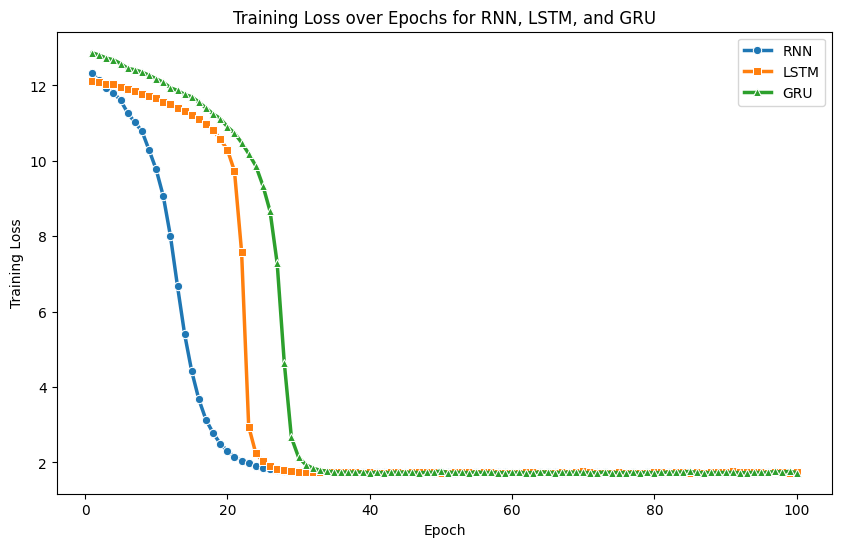

In [29]:
training_loss_RNN = resultRNN
training_loss_LSTM = resultLSTM
training_loss_GRU = resultGRU

plt.figure(figsize=(10, 6))
sns.lineplot(x=range(1, len(training_loss_RNN) + 1), y=training_loss_RNN, label='RNN', marker='o', linewidth=2.5)
sns.lineplot(x=range(1, len(training_loss_LSTM) + 1), y=training_loss_LSTM, label='LSTM', marker='s', linewidth=2.5)
sns.lineplot(x=range(1, len(training_loss_GRU) + 1), y=training_loss_GRU, label='GRU', marker='^', linewidth=2.5)

plt.title('Training Loss over Epochs for RNN, LSTM, and GRU')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

In [32]:
def find_best_epoch(metrics):
    best_index = min(range(len(metrics)), key=lambda i: metrics[i][0])  
    return metrics[best_index]


best_epoch_rnn = find_best_epoch(val_metrics_rnn)
best_epoch_lstm = find_best_epoch(val_metrics_lstm)
best_epoch_gru = find_best_epoch(val_metrics_gru)

metrics_df = pd.DataFrame({
    'Model': ['RNN', 'LSTM', 'GRU'],
    'Validation Loss': [best_epoch_rnn[0], best_epoch_lstm[0], best_epoch_gru[0]],
    'MAE': [best_epoch_rnn[1], best_epoch_lstm[1], best_epoch_gru[1]],
    'MAPE': [best_epoch_rnn[2], best_epoch_lstm[2], best_epoch_gru[2]],
    'R^2': [best_epoch_rnn[3], best_epoch_lstm[3], best_epoch_gru[3]],
    'IC': [best_epoch_rnn[4], best_epoch_lstm[4], best_epoch_gru[4]],
    'Rank IC': [best_epoch_rnn[5], best_epoch_lstm[5], best_epoch_gru[5]]
})

print(metrics_df)

  Model  Validation Loss             MAE             MAPE              R^2  \
0   RNN         2.160973  tensor(1.1518)  tensor(35.1261)  tensor(-8.7625)   
1  LSTM         2.157257  tensor(1.1529)  tensor(35.2852)  tensor(-7.3231)   
2   GRU         2.136253  tensor(1.1551)  tensor(35.8311)  tensor(-8.5611)   

         IC   Rank IC  
0  0.110413  0.130107  
1 -0.087110 -0.152910  
2  0.060404  0.006953  
